In [1]:
import scipy.io
import pandas as pd
import numpy as np
import re

from matplotlib import cm

In [2]:
def prt_create_dummy(fn='dummy.prt'):
    """create dummy empty prt file"""
    dummytxt = '\nFileVersion:        1\n\nResolutionOfTime:   Volumes\n\nExperiment:         <placeholderexpname>\n\nBackgroundColor:    0 0 0\nTextColor:          255 255 255\nTimeCourseColor:    255 255 255\nTimeCourseThick:    3\nReferenceFuncColor: 0 0 80\nReferenceFuncThick: 3\n\nNrOfConditions:     <placeholdernrconditions>\n\n'
    with open(fn, 'w') as f:
        f.write(dummytxt)
    return   


def prt_add_conditions(df, dummy_fn, new_fn):
    """add condition matrix to prt"""
    # load the dummy file
    f = open(dummy_fn,'r')
    dtxt = f.read()
    f.close

    # get new text
    newtxt = '{}{}'.format(dtxt, add_conditions(df))

    # save the file under new filename
    with open(new_fn, 'w') as f:
        f.write(newtxt)
    return
       
    
def prt_fill_placeholders(fn, expname, nrcond):
    """set parameters"""
    # load the file 
    f = open(fn,'r')
    dtxt = f.read()
    f.close()
    
    # substitude the placeholder names
    dtxt = re.sub('<placeholderexpname>', str(expname), dtxt)
    dtxt = re.sub('<placeholdernrconditions>', str(nrcond), dtxt)
    
    # resave the file
    with open(fn, 'w') as f:
        f.write(dtxt)
    return
 
    
def add_conditions(df):
    """add conditions based on columns of an input dataframe put in text format
    return array of strings"""
    # create empty array
    condstr_s = ''
    colors = color_grad(len(df.columns))
    clr_idx = 0
    # loop over all the conditions
    for colmn in df.columns:
        # get boolean encoding and set to volume numbers
        indx_val = np.array(df[colmn].index[df[colmn] == 1].to_list()) + 1      # take volume/idx of df columns
        vol_array = con_from_to(indx_val)                                       # get start / end volume
        # if column is a float, set to string and get color gradiant
        if is_float(colmn): 
            colmn = '{:0.3f}'.format(colmn)
            clr = colors[clr_idx]
            clr_idx += 1
        else:
            clr = None
        condstr = set_cond_str(colmn, vol_array, setcolor=clr)                    # put values in string format
        condstr_s += condstr                                                    # add all strings
    return(condstr_s)


def consecutive(data, stepsize=1):
    """get consec values in an array"""
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)


def con_from_to(data):
    """get from to value"""
    data = consecutive(data)
    return(np.array([[np.min(i), np.max(i)] for i in data]))
    
    
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
    
def random_rgb():
    """get a random, bright rgb color"""
    color = np.random.randint(0,256, size=2)
    color = np.append(color, 255)
    np.random.shuffle(color)
    return(color)


def set_cond_str(cond_nm, repsarray, setcolor=None):
    """generate string for the prt file (actual condition str)"""
    # loop over repetitions and put them in the correct text format
    rep_string = '' # start with empty string
    for reps in repsarray:
        rep_string += '{: 4d} {: 4d}\n'.format(reps[0], reps[1])
    
    # take random color
    if (setcolor is not None): curcolor = setcolor
    else: curcolor = random_rgb()

    # make current condtions string
    cond_str = '{}\n{}\n{}Color: {} {} {}\n\n'.format(cond_nm, len(repsarray), 
                                                      rep_string, curcolor[0], curcolor[1], 
                                                      curcolor[2])
    return(cond_str)


def consecutive(data, stepsize=1):
    """get consec values in an array"""
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)


def con_from_to(data):
    """get from to value"""
    data = consecutive(data,stepsize=0) # stepsize 0 is per volume encoding
    return(np.array([[np.min(i), np.max(i)] for i in data]))
    
    
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    

def rgb(x):
    """float to rgb"""
    return(int(np.round(x * 255)))

def color_grad(nr_col):
    cm_subsection = np.linspace(0, 1, nr_col)
    colors = np.array([ [rgb(cm.jet(x)[0]), rgb(cm.jet(x)[1]), rgb(cm.jet(x)[2])] for x in cm_subsection ])
    return(colors) 

## Load the desired file

In [4]:
pp = 3
run = 6
mat = scipy.io.loadmat('/media/jorvhar/Data8T/MRIData/timing data/data/{}/{}-r{}-tonotopy.mat'.format(pp, pp, run))

### These files contain:

CONDITIONS - `mat['conditions']`
1. Block
2. Freq
3. isgap
4. seq order
5. trial in block
6. expected presentation time

PULSEZ - `mat['pulsez']`
1. pulse
2. timing (triggertime)

TIMINGS - `mat['timingz']`
1. pulse onset (triggertime)
2. estimated audio onset
3. estimated audio offset
4. estimated presentation timing
5. estimated presentation delay after pulse
6. amount of presentation delay

## Put all usefull information into a single dataframe

In [5]:
# create dataframe for all the pulses
df = pd.DataFrame({'pulse': mat['pulsez'][0,:],
                   'timing': mat['pulsez'][1,:]})

# set conditions and timings temp df
temp_df = pd.DataFrame({'timing': mat['timingz'][0,:],
                        'block' : mat['conditions'][0,:],
                        'freq'  : mat['conditions'][1,:],
                        'isgap' : mat['conditions'][2,:],
                        'seqorder' : mat['conditions'][3,:],
                        'trialblock' : mat['conditions'][4,:]})

# merge the two together
df = pd.merge(df, temp_df, how='left', on=['timing'])

## Also take the conditiions from settings 
in order to get a more robust design matrix (i.e. for incoplete blocks)

In [7]:
mat = scipy.io.loadmat('/media/jorvhar/Data1/MRIData/timing data/data/{}/{}_settings_tonotopy.mat'.format(pp, pp))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

In [8]:
zero_array = np.zeros([len(df),len(all_freqs)]) # create zeros array in shape of pulses X nr_freqs
design_mat = pd.DataFrame(zero_array, columns=all_freqs)    # create design matrix dataframe

#### We can then relatively simple get a one hot encoding

In [9]:
# loop over all the volumes
for frq in range(len(df['freq'])):
    frq_val = df['freq'][frq]
                 
    # check if the value is nan
    if not np.isnan(frq_val):
        design_mat.at[frq, frq_val] = 1

In [10]:
# we can then do whatever with it, for example set it to a matrix
design_mat.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## get design matrix for sound on / off

In [11]:
# quickly make a design matrix for sound on vs off
sound_on = np.isnan(df['freq']) # make everything where we have a freqency 1
design_soundon = pd.DataFrame(sound_on.to_numpy(), columns=['soundon'])

In [12]:
# we can then do whatever with it, for example set it to a matrix
design_soundon.to_numpy();

## Optionally: combine the two

In [13]:
design_mat_full = design_mat.assign(soundon=design_soundon.to_numpy())
design_mat_full

,7.643856189774724,7.664387112768902,7.68491803576308,7.705448958757258,7.725979881751436,7.746510804745614,7.767041727739792,7.78757265073397,7.808103573728148,7.828634496722326,...,12.38649940142982,12.407030324423998,12.427561247418176,12.448092170412353,12.468623093406531,12.489154016400711,12.509684939394887,12.530215862389065,12.550746785383243,soundon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [14]:
design_mat_full.loc[:, 'soundon'] = 1 - design_mat_full.loc[:, 'soundon']

In [15]:
design_mat_full

,7.643856189774724,7.664387112768902,7.68491803576308,7.705448958757258,7.725979881751436,7.746510804745614,7.767041727739792,7.78757265073397,7.808103573728148,7.828634496722326,...,12.38649940142982,12.407030324423998,12.427561247418176,12.448092170412353,12.468623093406531,12.489154016400711,12.509684939394887,12.530215862389065,12.550746785383243,soundon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


###  binning frequencies

In [201]:
## BIN DATA
binsize = 10

# labels
data = np.array(list(design_mat.columns))
labels_bin = np.mean(data.reshape(-1, binsize), axis=1)

# actual data
design_arr = design_mat.to_numpy()
design_arr_bin = design_arr.reshape((design_arr.shape[0], int(design_arr.shape[1]/binsize), -1)).sum(axis=2)

design_bin_df = pd.DataFrame(design_arr_bin, columns= labels_bin)

In [202]:
# save combined matrix
prt_create_dummy(fn='dummy.prt')

# save design matrix of run
prt_add_conditions(design_bin_df, 'dummy.prt', 'r{}-tonotopy_binned.prt'.format(run))
prt_fill_placeholders('r{}-tonotopy_binned.prt'.format(run), 'r{}-tonotopy_binned'.format(run), len(design_bin_df.columns))

# convert to prt file

In [203]:
# save combined matrix
prt_create_dummy(fn='dummy.prt')
# design_mat_full.loc[:, 'soundon'] = 1 - design_mat_full.loc[:, 'soundon']  # get soundoff coding instead of soundon
prt_add_conditions(design_mat_full, 'dummy.prt', 'r{}-full-tonotopy.prt'.format(run))
prt_fill_placeholders('r{}-full-tonotopy.prt'.format(run), 'r{}-onoff'.format(run), len(design_mat_full.columns))

In [204]:
# save design matrix of run
prt_add_conditions(design_mat, 'dummy.prt', 'r{}-tonotopy.prt'.format(run))
prt_fill_placeholders('r{}-tonotopy.prt'.format(run), 'r{}-tonotopy'.format(run), len(design_mat.columns))

In [551]:
# save on off matrix
prt_add_conditions(1- design_soundon, 'dummy.prt', 'r{}-onoff-tonotopy.prt'.format(run))
prt_fill_placeholders('r{}-onoff-tonotopy.prt'.format(run), 'r{}-onoff'.format(run), 1)

In [521]:
fn = 'r{}-tonotopy.prt'.format(run)
txt = open(fn,'r')
for line in txt:
    print(line)



FileVersion:        1



ResolutionOfTime:   Volumes



Experiment:         r4-tonotopy



BackgroundColor:    0 0 0

TextColor:          255 255 255

TimeCourseColor:    255 255 255

TimeCourseThick:    3

ReferenceFuncColor: 0 0 80

ReferenceFuncThick: 3



NrOfConditions:     240



7.644

1

 269  269

Color: 0 0 128



7.664

1

  21   21

Color: 0 0 132



7.685

1

  55   55

Color: 0 0 137



7.705

1

 135  135

Color: 0 0 141



7.726

1

 198  198

Color: 0 0 146



7.747

1

  41   41

Color: 0 0 150



7.767

1

 236  236

Color: 0 0 155



7.788

1

  15   15

Color: 0 0 159



7.808

1

 170  170

Color: 0 0 164



7.829

1

  30   30

Color: 0 0 168



7.849

1

 158  158

Color: 0 0 173



7.870

1

 223  223

Color: 0 0 178



7.890

1

   6    6

Color: 0 0 182



7.911

1

  44   44

Color: 0 0 187



7.931

1

  67   67

Color: 0 0 191



7.952

1

 209  209

Color: 0 0 200



7.972

1

  79   79

Color: 0 0 205



7.993

1

 261  261

Color: 0 0 209



8.013

1


In [118]:
fn = 'r{}-onoff-tonotopy.prt'.format(run)
txt = open(fn,'r')
for line in txt:
    print(line)



FileVersion:        1



ResolutionOfTime:   Volumes



Experiment:         r6-onoff



BackgroundColor:    0 0 0

TextColor:          255 255 255

TimeCourseColor:    255 255 255

TimeCourseThick:    3

ReferenceFuncColor: 0 0 80

ReferenceFuncThick: 3



NrOfConditions:     1



soundon

16

   1    5

  11   11

  18   18

  20   20

  63   63

  90   97

 117  117

 128  128

 136  136

 144  144

 182  189

 195  195

 219  219

 243  243

 264  264

 274  278

Color: 206 130 255





In [119]:
fn = 'r{}-full-tonotopy.prt'.format(run)
txt = open(fn,'r')
for line in txt:
    print(line)



FileVersion:        1



ResolutionOfTime:   Volumes



Experiment:         r6-onoff



BackgroundColor:    0 0 0

TextColor:          255 255 255

TimeCourseColor:    255 255 255

TimeCourseThick:    3

ReferenceFuncColor: 0 0 80

ReferenceFuncThick: 3



NrOfConditions:     1



7.644

2

   1  166

 168  278

Color: 127 255 191



7.664

2

   1   25

  27  278

Color: 142 255 208



7.685

2

   1  246

 248  278

Color: 116 255 183



7.705

2

   1   43

  45  278

Color: 231 255 112



7.726

2

   1   74

  76  278

Color: 255 25 53



7.747

2

   1  196

 198  278

Color: 255 229 119



7.767

2

   1   47

  49  278

Color: 255 93 101



7.788

2

   1  221

 223  278

Color: 255 230 170



7.808

2

   1   38

  40  278

Color: 7 58 255



7.829

2

   1  101

 103  278

Color: 255 226 44



7.849

2

   1  260

 262  278

Color: 255 159 129



7.870

2

   1   33

  35  278

Color: 255 1 31



7.890

2

   1  163

 165  278

Color: 241 253 255



7.911

2

   1  105

 10

# save prt quicly

In [4]:
from os import makedirs
from os.path import join, exists


def create_prt(filepath, settingspath, run, outputfolder, saveonoff=True, savedesmat=True):
    """given filepath, settingspath, run number save prt for onoff (optionally) and/or designmatrix"""

    # load file from filepath
    mat = scipy.io.loadmat(filepath)

    # create dataframe for all the pulses
    df = pd.DataFrame({'pulse': mat['pulsez'][0,:],
                       'timing': mat['pulsez'][1,:]})

    # set conditions and timings temp df
    temp_df = pd.DataFrame({'timing': mat['timingz'][0,:],
                            'block' : mat['conditions'][0,:],
                            'freq'  : mat['conditions'][1,:],
                            'isgap' : mat['conditions'][2,:],
                            'seqorder' : mat['conditions'][3,:],
                            'trialblock' : mat['conditions'][4,:]})

    # merge the two together
    df = pd.merge(df, temp_df, how='left', on=['timing'])

    # load settings
    mat = scipy.io.loadmat(settingspath)
    all_freqs = mat['cfg']['freq_array'][0][0][0,:]

    # predefine zero array and full df
    zero_array = np.zeros([len(df),len(all_freqs)]) # create zeros array in shape of pulses X nr_freqs
    design_mat = pd.DataFrame(zero_array, columns=all_freqs)    # create design matrix dataframe

    # loop over all the volumes
    for frq in range(len(df['freq'])):
        frq_val = df['freq'][frq]

        # check if the value is nan
        if not np.isnan(frq_val):
            design_mat.at[frq, frq_val] = 1


    # quickly make a design matrix for sound on vs off
    sound_on = np.isnan(df['freq']) # make everything where we have a freqency 1
    design_soundon = pd.DataFrame(sound_on.to_numpy(), columns=['soundon'])

    # check if folder exists, if not create
    if not exists(outputfolder): makedirs(outputfolder)
    
    if saveonoff:
        # save on off matrix
        prt_add_conditions(1- design_soundon, 'dummy.prt', join(outputfolder, 'run{}-onoff-tonotopy.prt'.format(run)))
        prt_fill_placeholders(join(outputfolder, 'run{}-onoff-tonotopy.prt'.format(run)), 'r{}-onoff'.format(run), 1)

    if savedesmat:
        # save design matrix of run
        prt_add_conditions(design_mat, 'dummy.prt', join(outputfolder, 'run{}-tonotopy.prt'.format(run)))
        prt_fill_placeholders(join(outputfolder, 'run{}-tonotopy.prt'.format(run)), 'r{}-tonotopy'.format(run), len(design_mat.columns))

In [6]:
# create files in current folder for sellected pp
ppz = [3, 4, 5, 6, 7, 8, 9]
runz = [1,2,3,4,5,6]


for pp in ppz:
    
    settingspath = '/media/jorvhar/Data8T/MRIData/timing data/data/{}/{}_settings_tonotopy.mat'.format(pp, pp)
    outputfolder = '/media/jorvhar/Data8T/MRIData/PreProc/S0{}_SES1/prts'.format(pp)
    
    for run in runz:

        filepath = '/media/jorvhar/Data1/MRIData/timing data/data/{}/{}-r{}-tonotopy.mat'.format(pp, pp, run)
        
        create_prt(filepath, settingspath, run, outputfolder, saveonoff=True, savedesmat=True)

## make image

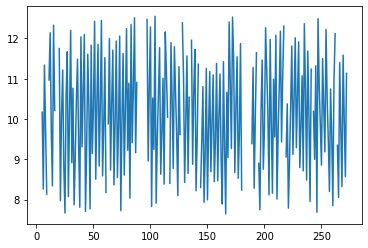

In [18]:
import matplotlib.pyplot as plt
plt.plot(df['freq'])


#tr = 1.8        # 12.6 is devidable by both
#preslen = 1.4

In [58]:
offperiod = np.zeros([df['freq'].to_numpy().shape[0], 2])
offperiod[:,:] = np.nan

paddedarray = np.repeat(df['freq'].to_numpy()[:, np.newaxis], 7, axis=1)
paddedarray = np.hstack((paddedarray, offperiod))
paddedarray = np.ndarray.flatten(paddedarray,  order='c')

secs = np.arange(0, len(paddedarray)*0.2, 0.2)

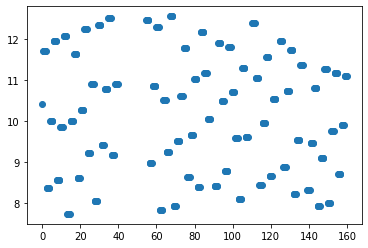

In [80]:
idx = np.where((secs >= 120) & (secs < 280))

plt.scatter(secs[:idx[0].shape[0]], paddedarray[idx])

In [81]:
import seaborn as sns

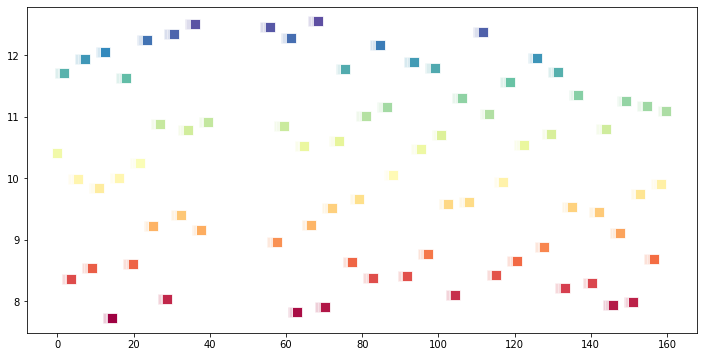

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))


ax = sns.scatterplot(x=secs[:idx[0].shape[0]], y=paddedarray[idx], hue=paddedarray[idx], palette='Spectral',
                    s=100, units=True, alpha=1, legend=False, marker='s')


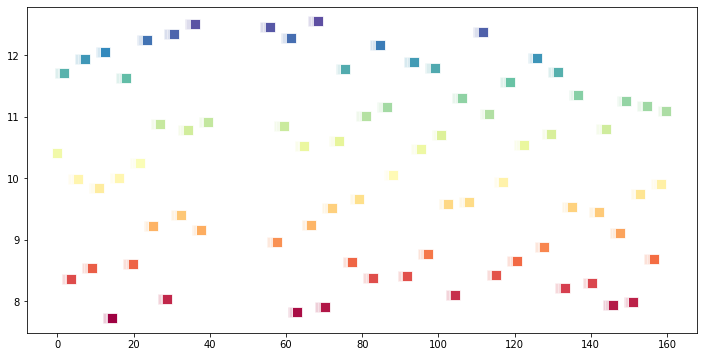

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax = sns.scatterplot(x=secs[:idx[0].shape[0]], y=paddedarray[idx], hue=paddedarray[idx], palette='Spectral',
                    s=100, units=False, alpha=1, legend=False, marker='s', zorder=2)


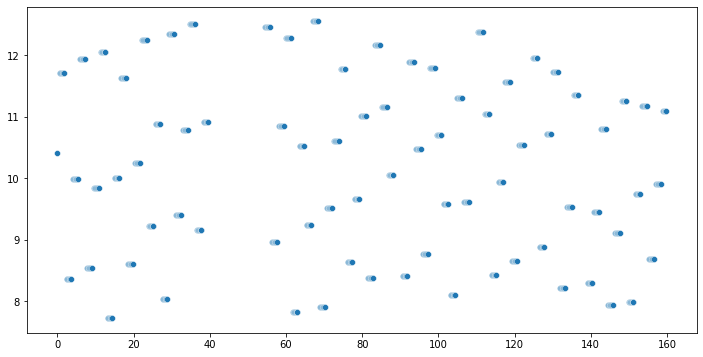

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax = sns.scatterplot(x=secs[:idx[0].shape[0]], y=paddedarray[idx], alpha=1.0)


In [137]:
secs[:idx[0].shape[0] :-1]


array([500.2, 500. , 499.8, ..., 160.6, 160.4, 160.2])

In [124]:
secs[:idx[0].shape[0]]

array([  0. ,   0.2,   0.4,   0.6,   0.8,   1. ,   1.2,   1.4,   1.6,
         1.8,   2. ,   2.2,   2.4,   2.6,   2.8,   3. ,   3.2,   3.4,
         3.6,   3.8,   4. ,   4.2,   4.4,   4.6,   4.8,   5. ,   5.2,
         5.4,   5.6,   5.8,   6. ,   6.2,   6.4,   6.6,   6.8,   7. ,
         7.2,   7.4,   7.6,   7.8,   8. ,   8.2,   8.4,   8.6,   8.8,
         9. ,   9.2,   9.4,   9.6,   9.8,  10. ,  10.2,  10.4,  10.6,
        10.8,  11. ,  11.2,  11.4,  11.6,  11.8,  12. ,  12.2,  12.4,
        12.6,  12.8,  13. ,  13.2,  13.4,  13.6,  13.8,  14. ,  14.2,
        14.4,  14.6,  14.8,  15. ,  15.2,  15.4,  15.6,  15.8,  16. ,
        16.2,  16.4,  16.6,  16.8,  17. ,  17.2,  17.4,  17.6,  17.8,
        18. ,  18.2,  18.4,  18.6,  18.8,  19. ,  19.2,  19.4,  19.6,
        19.8,  20. ,  20.2,  20.4,  20.6,  20.8,  21. ,  21.2,  21.4,
        21.6,  21.8,  22. ,  22.2,  22.4,  22.6,  22.8,  23. ,  23.2,
        23.4,  23.6,  23.8,  24. ,  24.2,  24.4,  24.6,  24.8,  25. ,
        25.2,  25.4,